# 03_threshold_calibration.ipynb

## Threshold Calibration & Model Evaluation

In this notebook, we’ll:
1. Load the cleaned data and trained model  
2. Define features and true labels  
3. Split into train/test sets  
4. Compute anomaly scores and plot ROC curve (AUC)  
5. Choose ROC‐based threshold (Youden’s J) and report metrics  
6. Plot Precision–Recall curve (AP)  
7. Choose PR‐based threshold (max F1) and report metrics  

### Imports & Environment Check

In [1]:

import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, auc,
    confusion_matrix, classification_report,
    precision_recall_curve, average_precision_score
)

# Show where we are and what folders exist
print("CWD:", os.getcwd())
print("Contents:", os.listdir(".."))
print("Data processed:", os.listdir("../data/processed"))
print("Models:", os.listdir("../models"))

CWD: /Users/anesuruzvidzo/Desktop/cyber_anomaly_detection/notebooks
Contents: ['.DS_Store', 'models', 'dashboard', 'scripts', 'data', 'notebooks', 'reports']
Data processed: ['cidds_week1_cleaned.csv']
Models: ['iso_tuned.pkl']


### Load Cleaned Data & Model

In [2]:

df = pd.read_csv("../data/processed/cidds_week1_cleaned.csv")

# Auto‐select numeric features, drop label columns
feature_cols = (
    df.select_dtypes(include="number")
      .columns
      .drop(["label", "predicted_anomaly"])
      .tolist()
)
X = df[feature_cols]
y = df["label"]  # already 0/1

# Load trained IsolationForest
iso = joblib.load("../models/iso_tuned.pkl")
print("Using features:", feature_cols)
print("Model loaded:", iso)

Using features: ['Duration', 'Src Pt', 'Dst Pt', 'Packets', 'Bytes', 'Flows', 'Tos']
Model loaded: IsolationForest(contamination=0.3, random_state=42)


### Train/Test Split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
print("Test-set size:", X_test.shape[0])

Test-set size: 47085


## Step 1: ROC Curve & AUC  
Compute and plot the ROC curve using flipped anomaly scores (higher = more anomalous).

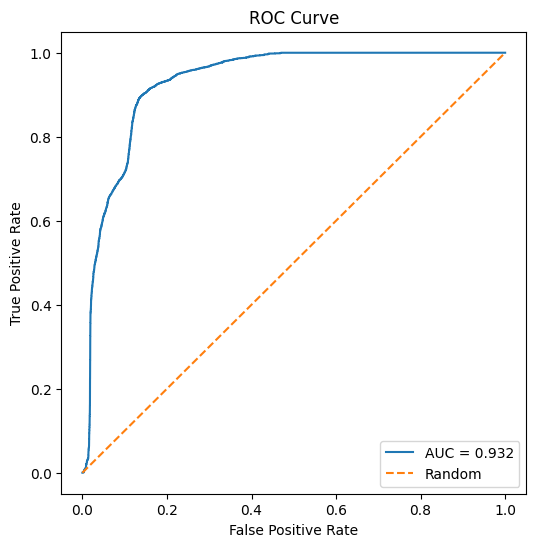

In [4]:
# 1. Get anomaly scores and flip sign
scores = iso.decision_function(X_test)
anom_scores = -scores

# 2. Compute ROC curve and AUC
fpr, tpr, roc_thresh = roc_curve(y_test, anom_scores)
roc_auc = auc(fpr, tpr)

# 3. Plot ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], "--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

## Step 2: Optimal ROC‐Based Threshold (Youden’s J)  
Select the threshold that maximizes (TPR – FPR) and report metrics.

In [5]:
# 1. Find Youden's J
youden_idx = (tpr - fpr).argmax()
roc_opt_thresh = roc_thresh[youden_idx]
print(f"ROC-optimal threshold (Youden’s J): {roc_opt_thresh:.4f}")

# 2. Metrics at that threshold
y_pred_roc = (anom_scores >= roc_opt_thresh).astype(int)
print("Confusion Matrix (ROC threshold):")
print(confusion_matrix(y_test, y_pred_roc))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_roc))

ROC-optimal threshold (Youden’s J): -0.0489
Confusion Matrix (ROC threshold):
[[12806  2066]
 [ 3319 28894]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.86      0.83     14872
           1       0.93      0.90      0.91     32213

    accuracy                           0.89     47085
   macro avg       0.86      0.88      0.87     47085
weighted avg       0.89      0.89      0.89     47085



## Step 3: Precision–Recall Curve & Average Precision  
Plot precision vs. recall at different anomaly‐score thresholds and compute the Average Precision (AP) score.

Average Precision (AP): 0.941


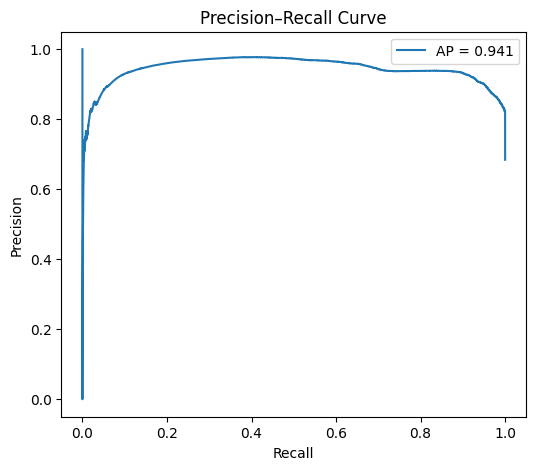

In [6]:
precision, recall, pr_thresh = precision_recall_curve(y_test, anom_scores)
ap = average_precision_score(y_test, anom_scores)
print(f"Average Precision (AP): {ap:.3f}")

# Plot PR curve
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend(loc="upper right")
plt.show()

## Step 4: Optimal PR‐Based Threshold (Max F1) & Metrics  
Find the threshold on the PR curve that maximizes F1, then report final metrics.

In [7]:
# 1. Compute F1 for each PR threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.nanargmax(f1_scores)
pr_opt_thresh = pr_thresh[best_idx]
print(f"PR-optimal threshold (max F1): {pr_opt_thresh:.4f} → F1 = {f1_scores[best_idx]:.3f}")

# 2. Metrics at PR-optimal threshold
y_pred_pr = (anom_scores >= pr_opt_thresh).astype(int)
print("Confusion Matrix (PR threshold):")
print(confusion_matrix(y_test, y_pred_pr))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_pr))

PR-optimal threshold (max F1): -0.0621 → F1 = 0.925
Confusion Matrix (PR threshold):
[[11504  3368]
 [ 1618 30595]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.77      0.82     14872
           1       0.90      0.95      0.92     32213

    accuracy                           0.89     47085
   macro avg       0.89      0.86      0.87     47085
weighted avg       0.89      0.89      0.89     47085



## Step 5: Model Explainability via Permutation Importance  
Assess feature importances by measuring how permuting each feature affects the model’s ROC AUC.

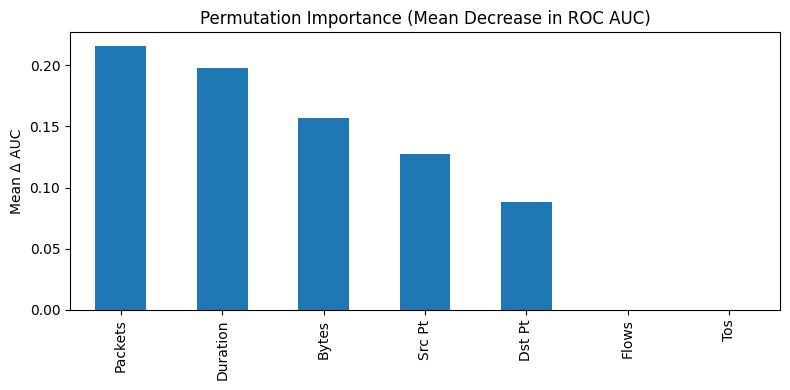

In [9]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score

# 1. Define a scorer that uses our anomaly scores (flip decision_function)
def roc_auc_scorer(estimator, X, y):
    # higher anom_scores = more likely to be anomaly
    scores = -estimator.decision_function(X)
    return roc_auc_score(y, scores)

# 2. Compute permutation importances on the test set
results = permutation_importance(
    iso, 
    X_test, 
    y_test, 
    scoring=roc_auc_scorer, 
    n_repeats=10, 
    random_state=42,
    n_jobs=-1
)

# 3. Aggregate into a Series and sort
import pandas as pd

perm_importance = pd.Series(
    results.importances_mean, 
    index=X_test.columns
).sort_values(ascending=False)

# 4. Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
perm_importance.plot.bar()
plt.title("Permutation Importance (Mean Decrease in ROC AUC)")
plt.ylabel("Mean Δ AUC")
plt.tight_layout()
plt.show()

## Step 6: Compare with LocalOutlierFactor  
Fit a LOF with the same assumed contamination (e.g. 30%) in novelty mode, score the test set, and compare ROC/AUC and metrics.

/Users/anesuruzvidzo/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


LOF ROC AUC: 0.534 (vs IsolationForest AUC = 0.932)


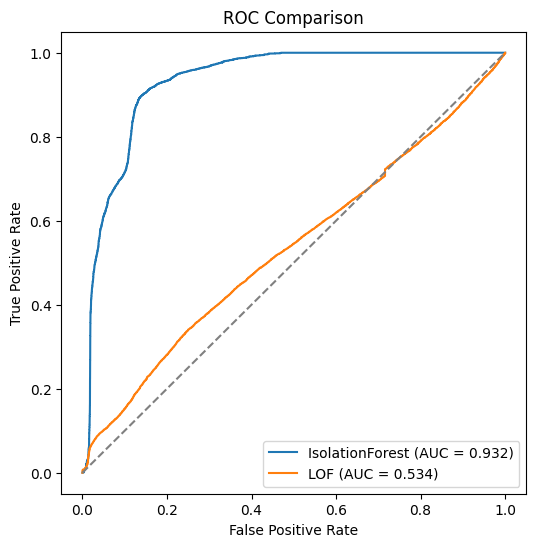

LOF Confusion Matrix (ISO threshold):
[[ 4136 10736]
 [ 8772 23441]]

LOF Classification Report:
              precision    recall  f1-score   support

           0       0.32      0.28      0.30     14872
           1       0.69      0.73      0.71     32213

    accuracy                           0.59     47085
   macro avg       0.50      0.50      0.50     47085
weighted avg       0.57      0.59      0.58     47085



In [11]:
from sklearn.neighbors import LocalOutlierFactor

# 1. Grab the original contamination rate from our IsolationForest
contamination = iso.contamination  # e.g. 0.3

# 2. Instantiate LOF for novelty detection
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=contamination,
    novelty=True          # allow scoring on new data
)

# 3. Fit on the training set
lof.fit(X_train)

# 4. Compute anomaly scores on X_test (flip so higher = more anomalous)
lof_scores = lof.decision_function(X_test)   # higher = more “normal”
lof_anom_scores = -lof_scores

# 5. ROC & AUC for LOF
from sklearn.metrics import roc_curve, auc
fpr_lof, tpr_lof, _ = roc_curve(y_test, lof_anom_scores)
roc_auc_lof = auc(fpr_lof, tpr_lof)
print(f"LOF ROC AUC: {roc_auc_lof:.3f} (vs IsolationForest AUC = {roc_auc:.3f})")

# 6. Plot both ROC curves
import matplotlib.pyplot as plt
plt.figure(figsize=(6,6))
plt.plot(fpr,     tpr,     label=f"IsolationForest (AUC = {roc_auc:.3f})")
plt.plot(fpr_lof, tpr_lof, label=f"LOF (AUC = {roc_auc_lof:.3f})")
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Comparison")
plt.legend(loc="lower right")
plt.show()

# 7. Metrics at the ISO‐chosen threshold for LOF
from sklearn.metrics import confusion_matrix, classification_report
y_pred_lof = (lof_anom_scores >= roc_opt_thresh).astype(int)
print("LOF Confusion Matrix (ISO threshold):")
print(confusion_matrix(y_test, y_pred_lof))
print("\nLOF Classification Report:")
print(classification_report(y_test, y_pred_lof))